# Reaction Advection Diffusion Equations

In [71]:
import torch
from torch import nn
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
from typing import Optional, Callable, Tuple
from torch.nn import functional as F
import PIL
import os

@torch.inference_mode()
def spatial_gradient(data: torch.Tensor, dx: float = 0.1) -> Tuple[torch.Tensor, torch.Tensor]:
    # data: C, ...K spatial dims, return K, C, ... K spatial dims
    return torch.stack(torch.gradient(data, spacing=dx, dim=list(range(1, data.ndim))))


spatial_laplacian_conv_kernel = torch.tensor([[[[0, 1, 0], [1, -4, 1], [0, 1, 0]]]], dtype=torch.float32)

@torch.inference_mode()
def spatial_laplacian(data: torch.Tensor) -> torch.Tensor:
    # data and output are C, H, W
    C, H, W = data.shape
    return F.conv2d(input=data.view(1, C, H, W), weight=spatial_laplacian_conv_kernel.expand([3, 3, 3, 3]), padding=1)[0]


@torch.inference_mode()
def simulate(
    frames: torch.Tensor, 
    interaction_callable: Callable[[torch.Tensor], torch.Tensor],
    D: torch.Tensor,
    v: torch.Tensor,
    dt: float,
) -> torch.Tensor:
    # frames: T, C, H, W
    num_frames, num_components, height, width = frames.shape
    D = D.view(num_components, 1, 1)
    for t in range(num_frames - 1):
        interaction = interaction_callable(frames[t])
        gradient = spatial_gradient(frames[t])
        laplacian = spatial_laplacian(frames[t])
        frames[t+1] = frames[t] + dt * (D * laplacian + (torch.einsum("i,i...->...", v, gradient)) + interaction)
    return frames


@torch.inference_mode()
def animate(frames: torch.Tensor, path: str, overwrite: bool = False) -> None:
    if (not overwrite) and (os.exists(path)):
        raise FileExistsError(f"{path=} already exists")

    from IPython.display import Image, display
    images = (frames * 255).byte()

    # Convert the tensor to a list of PIL Images
    image_list = [PIL.Image.fromarray(image.permute(1, 2, 0).numpy()) for image in images]

    # Save the list of PIL Images as a GIF
    os.makedirs(os.path.dirname(path), exist_ok=True)
    image_list[0].save(path, save_all=True, append_images=image_list[1:], duration=200, loop=0)
    display(Image(filename=path))

In [42]:
def _randn_initialization(_frames: torch.Tensor) -> None:
    _frames[0] = torch.randn(_frames.shape[1], _frames.shape[2], _frames.shape[3], dtype=torch.float32).clip(0, 1.0)

def _ring_initialization(_frames: torch.Tensor) -> None:
    xs = torch.linspace(-0.5, 0.5, steps=_frames.shape[2])
    ys = torch.linspace(-0.5, 0.5, steps=_frames.shape[3])
    y, x = torch.meshgrid(xs, ys, indexing="xy")
    r = torch.sqrt(torch.pow(x, 2) + torch.pow(y, 2))
    _frames[0, 0] = torch.sin(2 * 3.14 * r)
    _frames[0, 1] = torch.sin(4 * 3.14 * r)
    _frames[0, 2] = torch.sin(8 * 3.14 * r)


In [38]:
def self_inhibition_social_catalysis(data: torch.Tensor) -> torch.Tensor:
    interaction = np.zeros_like(data)
    interaction[0] = -data[0] + data[1] + data[2]
    interaction[1] = data[0] - data[1] + data[2]
    interaction[2] = data[0] + data[1] - data[2]
    return interaction

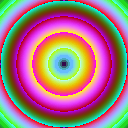

CPU times: user 2.27 s, sys: 77.2 ms, total: 2.34 s
Wall time: 1.76 s


In [77]:
%%time
num_frames = 128
size = 128
num_channels = 3  # RGB

frames = torch.zeros(num_frames, num_channels, size, size, dtype=torch.float32)
_ring_initialization(frames)
frames = simulate(
    frames,
    self_inhibition_social_catalysis,
    D=torch.tensor([0.1, -0.1, 0.2]),
    v=torch.tensor([0.5, 0.5]),
    dt=0.05,
)
animate(frames, "../outputs/debug.gif", overwrite=True)